In [1]:
#!/usr/bin/env python 
import sys
import os
import time
import subprocess as sp
import itertools
import pandas as pd
## CV
import cv2
import skvideo.io
import matplotlib.pyplot as plt
%matplotlib inline
## Model
import numpy as np
import tensorflow as tf
## Tools
import utils
## Parameters
import params ## you can modify the content of params.py

from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU, Cropping2D, BatchNormalization
from keras.layers import TimeDistributed, Convolution2D, Input
from keras.layers import Conv2D, SpatialDropout2D, LSTM, MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import regularizers
from keras.preprocessing.image import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Test epoch
epoch_ids = range(1,11)
## Load model
#model = utils.get_model()

## Preprocess
def img_pre_process(img):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
    img = img[int(shape[0]/2):shape[0]-150, 0:shape[1]]
    ## Resize the image
    img = cv2.resize(img, (params.FLAGS.img_w, params.FLAGS.img_h), interpolation=cv2.INTER_AREA)
    ## Return the image sized as a 4D array
    
    return np.resize(img, (params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c))
def img_pre_process2(img):
    ratio = params.FLAGS.img_h / params.FLAGS.img_w
    h1, h2 = int(img.shape[0] / 2), img.shape[0] - 150
    w = (h2 - h1) / ratio
    padding = int(round((img.shape[1] - w) / 2))
    img = img[h1:h2, padding:-padding]
    # Resize the image
    img = cv2.resize(img, (params.FLAGS.img_w, params.FLAGS.img_h),
                     interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return img

## Process video
def extract_frames(mode='load'):
    image_set = []
    steerings = []
    image_set_test = []
    steerings_test = []
    for epoch_id in epoch_ids:
        print('---------- processing video for epoch {} ----------'.format(epoch_id))
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(epoch_id))
        csv_path = "./epochs/epoch{:0>2d}_steering.csv".format(epoch_id)
        dir_name = "./epochs/epoch{:0>2d}_front_frames".format(epoch_id)
        steering = pd.read_csv(csv_path)['wheel'].tolist()
        if epoch_id == max(epoch_ids):
            steerings_test.extend(steering)
        else:
            steerings.extend(steering)
        
        if mode == 'save':
            os.mkdir(dir_name)
        frame_ids = pd.read_csv(csv_path)['ts_micro'].tolist()
        assert os.path.isfile(vid_path)
        frame_count = utils.frame_count(vid_path)
        cap = skvideo.io.vreader(vid_path) #cv2.VideoCapture(vid_path)

        machine_steering = []

        print('performing inference...')
        time_start = time.time()
        frame_count = 0
        for img in cap:
            #assert img
            ## you can modify here based on your model
            #print(img.shape)
            #cv2.imshow('frame',img)
            img = img_pre_process2(img)
            if mode == 'save':
                cv2.imwrite("{}/{}.jpg".format(dir_name, frame_ids[frame_count-1]), img)
            elif mode == 'load':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                #img = preprocessing.normalize(img, norm='l2')
                img_f = np.flip(img,1)
                if epoch_id == max(epoch_ids):
                    image_set_test.append(img)
                else:
                    image_set.append(img)
                    image_set.append(img_f)
                #steerings.append(frame_ids[frame_count-1])
            #deg = float(model.predict(img, batch_size=1))
            #machine_steering.append(deg)
            frame_count += 1

        del cap

        fps = frame_count / (time.time() - time_start)
    
        print('completed inference, total frames: {}, average fps: {} Hz'.format(frame_count, round(fps, 1)))
    return np.array(image_set), np.array(steerings), np.array(image_set_test), np.array(steerings_test)
    
        #print('performing visualization...')
        #utils.visualize(epoch_id, machine_steering, params.out_dir,
                            #verbose=True, frame_count_limit=None)
            
            

Using TensorFlow backend.


In [2]:
def load_dataset():
    image_set = []
    steerings = []
    for epoch_id in epoch_ids:
        csv_path = "./epochs/epoch{:0>2d}_steering.csv".format(epoch_id)
        dir_name = "./epochs/epoch{:0>2d}_front_frames".format(epoch_id)
        filenames = pd.read_csv(csv_path)['ts_micro'].tolist()
        steering = pd.read_csv(csv_path)['wheel'].tolist()
        steerings.extend(steering)
        #print(steerings)
        for img in filenames:
            image = cv2.imread(dir_name+str(img)+'.jpg')
            #assert image
            if image == None:
                print(img)
            image_set.append(image)
    return np.array(image_set), np.array(steerings)       
            
            
#extract_frames()
X, y, X_test, y_test = extract_frames(mode='load') #load_dataset()
print(X.shape, y.shape)
    
    

---------- processing video for epoch 1 ----------
performing inference...
completed inference, total frames: 1500, average fps: 227.7 Hz
---------- processing video for epoch 2 ----------
performing inference...
completed inference, total frames: 3900, average fps: 237.0 Hz
---------- processing video for epoch 3 ----------
performing inference...
completed inference, total frames: 2700, average fps: 230.6 Hz
---------- processing video for epoch 4 ----------
performing inference...
completed inference, total frames: 2700, average fps: 237.2 Hz
---------- processing video for epoch 5 ----------
performing inference...
completed inference, total frames: 2700, average fps: 234.4 Hz
---------- processing video for epoch 6 ----------
performing inference...
completed inference, total frames: 2700, average fps: 232.6 Hz
---------- processing video for epoch 7 ----------
performing inference...
completed inference, total frames: 2700, average fps: 233.0 Hz
---------- processing video for ep

In [3]:
#table = pd.read_csv('./epochs/epoch01_steering.csv')
#steering = table['wheel'].tolist()
#print(steering)

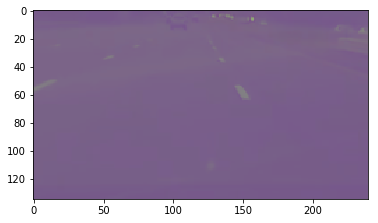

In [4]:
#y_train = np.multiply(np.add(y, 18), 2)
#y_train = to_categorical(y_train)
plt.imshow(X[1])

In [5]:
datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True)
datagen.fit(X)

KeyboardInterrupt: 

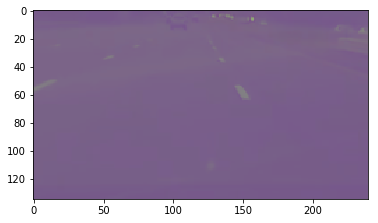

In [5]:
plt.imshow(X[1])

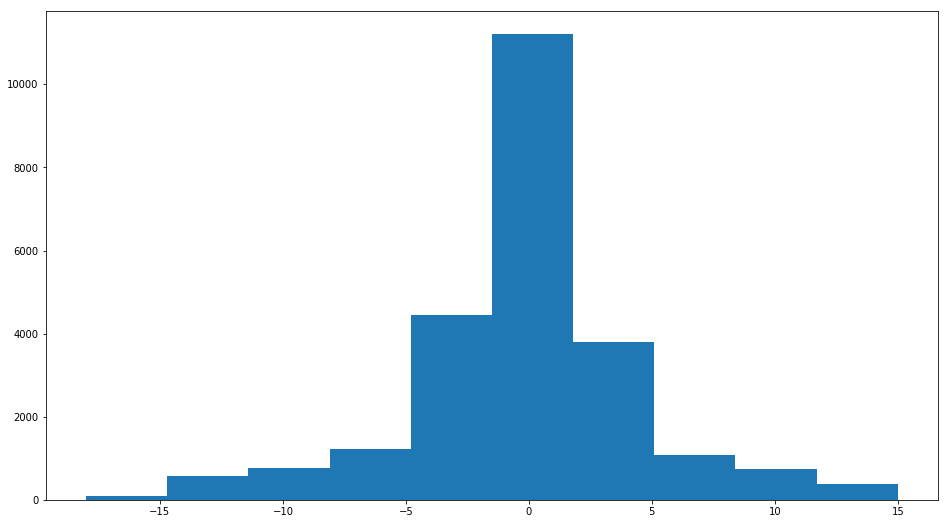

In [6]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.hist(y)
plt.savefig("y_distribute.png", dpi=333)
plt.show()

In [7]:
y_train = np.multiply(np.add(y, 18), 2)
y_train = to_categorical(y_train)
y_f = []
for mini_y in y:
    y_f.append(mini_y)
    y_f.append(-mini_y)
y_f = np.array(y_f)
print(X.shape, y_f.shape)
#print(y[0:10], y_train[0:10])

(48600, 135, 240, 3) (48600,)


from keras import backend as K
K.clear_session()
image_shape = (time_step, params.FLAGS.img_w, params.FLAGS.img_h, 3)

model = Sequential()
#model.add(Lambda(lambda x: x / 225.0 - 0.5, input_shape=image_shape))
#model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(TimeDistributed(Conv2D(24, (5,5), strides=(2,2), activation=None), input_shape=image_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(Activation('relu'))
model.add(TimeDistributed(SpatialDropout2D(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(units=100, return_sequences=True))
model.add(TimeDistributed(Dense(1)))

In [8]:
def base_model():
    image_shape = (params.FLAGS.img_h, params.FLAGS.img_w, 3)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    #model.add(Cropping2D(cropping=((70,25), (0,0))))

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

def pool_model():
    image_shape = (params.FLAGS.img_h, params.FLAGS.img_w, 3)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    #model.add(Cropping2D(cropping=((70,25), (0,0))))

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model
    
def reg_model():
    image_shape = (params.FLAGS.img_h, params.FLAGS.img_w, 3)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    #model.add(Cropping2D(cropping=((70,25), (0,0))))

    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1164, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))
    model.compile(loss='mse', optimizer='adam')
    return model
    
    
def bn_model():
    
    image_shape = (params.FLAGS.img_h, params.FLAGS.img_w, 3)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    #model.add(Cropping2D(cropping=((70,25), (0,0))))

    model.add(Conv2D(24, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1164, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))
    model.compile(loss='mse', optimizer='adam')
    return model
    
def elu_model():
    image_shape = (params.FLAGS.img_h, params.FLAGS.img_w, 3)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    #model.add(Cropping2D(cropping=((70,25), (0,0))))

    model.add(Conv2D(24, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1164, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [9]:


def he_model():
    image_shape = (params.FLAGS.img_h, params.FLAGS.img_w, 3)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0, input_shape=image_shape))
    #model.add(Cropping2D(cropping=((70,25), (0,0))))

    model.add(Conv2D(24, (5,5), strides=(2,2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(36, (5,5), strides=(2,2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(48, (5,5), strides=(2,2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(64, (3,3), strides=(1,1), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1164, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='he_normal', name='preds'))
    model.compile(loss='mse', optimizer='adam')
    return model

In [10]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
def save_model_json(model, filename):
    model_json = model.to_json()
    with open("./models/"+filename, 'w') as json_file:
        json_file.write(model_json)

    

In [11]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plt.rcParams['figure.figsize'] = (3, 1)
#plot_model(he_model, to_file='model.png', show_shapes=True)
#Image(filename = 'model.png')

In [12]:
#print(X.shape)
#X_time = X.reshape(24300,1,64,64,3)
#y_time = y.reshape(24300,1,1)
#plt.imshow(X_time[1,1])

In [13]:
base_model = base_model()
save_model_json(base_model, "base_model.json")

history_object_base = base_model.fit(X,
                           y_f,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=10,
                           shuffle=True)

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 43s 1ms/step - loss: 22.8465 - val_loss: 14.3261
Epoch 2/10
38880/38880 [==============================] - 39s 997us/step - loss: 22.8436 - val_loss: 14.3261
Epoch 3/10
38880/38880 [==============================] - 39s 1ms/step - loss: 22.8437 - val_loss: 14.3261
Epoch 4/10
38880/38880 [==============================] - 39s 1ms/step - loss: 22.8437 - val_loss: 14.3261
Epoch 5/10
38880/38880 [==============================] - 39s 1ms/step - loss: 22.8437 - val_loss: 14.3261
Epoch 6/10
38880/38880 [==============================] - 39s 1ms/step - loss: 22.8437 - val_loss: 14.3261
Epoch 7/10
38880/38880 [==============================] - 39s 1ms/step - loss: 22.8437 - val_loss: 14.3261
Epoch 8/10
38880/38880 [==============================] - 39s 1ms/step - loss: 22.8437 - val_loss: 14.3261
Epoch 9/10
38880/38880 [==============================] - 39s 1ms/step - loss: 22.8436 - val_

In [14]:
test_loss= base_model.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 1s 488us/step
Test loss is:7.852017733079416


pool_model = pool_model()
save_model_json(pool_model, "pool_model.json")

history_object_pool = pool_model.fit(X,
                           y_f,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=10,
                           shuffle=True)

test_loss= pool_model.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

In [15]:
reg_model = reg_model()
save_model_json(reg_model, "reg_model.json")

history_object_reg = reg_model.fit(X,
                           y_f,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=10,
                           shuffle=True)

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 22s 562us/step - loss: 23.5059 - val_loss: 14.3946
Epoch 2/10
38880/38880 [==============================] - 21s 552us/step - loss: 22.8777 - val_loss: 14.3421
Epoch 3/10
38880/38880 [==============================] - 21s 551us/step - loss: 22.8535 - val_loss: 14.3317
Epoch 4/10
38880/38880 [==============================] - 21s 549us/step - loss: 22.8472 - val_loss: 14.3282
Epoch 5/10
38880/38880 [==============================] - 21s 553us/step - loss: 22.8450 - val_loss: 14.3269
Epoch 6/10
38880/38880 [==============================] - 21s 547us/step - loss: 22.8444 - val_loss: 14.3264
Epoch 7/10
38880/38880 [==============================] - 21s 548us/step - loss: 22.8438 - val_loss: 14.3262
Epoch 8/10
38880/38880 [==============================] - 21s 551us/step - loss: 22.8438 - val_loss: 14.3261
Epoch 9/10
38880/38880 [==============================] - 21s 552us/step - loss

In [16]:
test_loss= reg_model.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 1s 336us/step
Test loss is:7.874421785672506


In [17]:
bn_model = bn_model()
save_model_json(bn_model, "bn_model.json")

history_object_bn = bn_model.fit(X,
                           y_f,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=20,
                           shuffle=True)

Train on 38880 samples, validate on 9720 samples
Epoch 1/20
38880/38880 [==============================] - 30s 783us/step - loss: 25.2096 - val_loss: 15.6410
Epoch 2/20
38880/38880 [==============================] - 30s 763us/step - loss: 16.3268 - val_loss: 16.7760
Epoch 3/20
38880/38880 [==============================] - 30s 763us/step - loss: 8.6480 - val_loss: 9.2931
Epoch 4/20
38880/38880 [==============================] - 30s 763us/step - loss: 7.1190 - val_loss: 10.2495
Epoch 5/20
38880/38880 [==============================] - 30s 764us/step - loss: 6.6026 - val_loss: 8.5465
Epoch 6/20
38880/38880 [==============================] - 30s 764us/step - loss: 6.3712 - val_loss: 9.3542
Epoch 7/20
38880/38880 [==============================] - 30s 766us/step - loss: 6.1001 - val_loss: 12.3023
Epoch 8/20
38880/38880 [==============================] - 30s 765us/step - loss: 5.8634 - val_loss: 11.3755
Epoch 9/20
38880/38880 [==============================] - 30s 765us/step - loss: 5.7657 

In [18]:
test_loss= bn_model.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 1s 391us/step
Test loss is:8.623592738398798


In [19]:
elu_model = elu_model()
save_model_json(elu_model, "elu_model.json")

history_object_elu = elu_model.fit(X,
                           y_f,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=20,
                           shuffle=True)

Train on 38880 samples, validate on 9720 samples
Epoch 1/20
38880/38880 [==============================] - 31s 792us/step - loss: 17.8792 - val_loss: 15.4930
Epoch 2/20
38880/38880 [==============================] - 30s 767us/step - loss: 8.7942 - val_loss: 11.4780
Epoch 3/20
38880/38880 [==============================] - 30s 766us/step - loss: 6.7777 - val_loss: 12.7245
Epoch 4/20
38880/38880 [==============================] - 30s 768us/step - loss: 5.8138 - val_loss: 11.8037
Epoch 5/20
38880/38880 [==============================] - 30s 769us/step - loss: 5.2157 - val_loss: 9.0680
Epoch 6/20
38880/38880 [==============================] - 30s 767us/step - loss: 4.7653 - val_loss: 8.6219
Epoch 7/20
38880/38880 [==============================] - 30s 769us/step - loss: 4.5258 - val_loss: 9.2035
Epoch 8/20
38880/38880 [==============================] - 30s 770us/step - loss: 4.2975 - val_loss: 9.0164
Epoch 9/20
38880/38880 [==============================] - 30s 769us/step - loss: 4.1738 - 

In [20]:
test_loss= elu_model.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 1s 401us/step
Test loss is:6.843750231707538


In [21]:
from keras.callbacks import ModelCheckpoint
filepath="./models/he_weights-improvement-{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
he_model = he_model()
save_model_json(he_model, "hemodel.json")

history_object_he = he_model.fit(X,
                           y_f,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=20,
                           shuffle=True,
                           callbacks=callbacks_list)

Train on 38880 samples, validate on 9720 samples
Epoch 1/20
38880/38880 [==============================] - 32s 819us/step - loss: 39.3987 - val_loss: 27.5376
Epoch 2/20
38880/38880 [==============================] - 30s 772us/step - loss: 19.9011 - val_loss: 18.5120
Epoch 3/20
38880/38880 [==============================] - 30s 772us/step - loss: 12.7109 - val_loss: 13.4140
Epoch 4/20
38880/38880 [==============================] - 30s 774us/step - loss: 9.0320 - val_loss: 10.4795
Epoch 5/20
38880/38880 [==============================] - 30s 773us/step - loss: 7.1169 - val_loss: 9.3796
Epoch 6/20
38880/38880 [==============================] - 30s 773us/step - loss: 5.9534 - val_loss: 8.3317
Epoch 7/20
38880/38880 [==============================] - 30s 770us/step - loss: 5.3417 - val_loss: 12.7823
Epoch 8/20
38880/38880 [==============================] - 30s 771us/step - loss: 4.7880 - val_loss: 7.6035
Epoch 9/20
38880/38880 [==============================] - 30s 772us/step - loss: 4.4899

In [22]:
test_loss= he_model.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 1s 406us/step
Test loss is:5.014714644396746


In [23]:
he_model.save('./models/model.h5')

In [26]:
he_model.load_weights('./models/model.h5')
test_loss= he_model.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 1s 402us/step
Test loss is:5.014714553974293


In [27]:
#define alexnet
LEARNING_RATE=0.01
MOMENTUM=0.9
ALPHA=0.0001
BETA=0.75
GAMMA=0.1
DROPOUT=0.5
WEIGHT_DECAY=0.0005
LRN2D_NORM=True
DATA_FORMAT='channels_last'

from keras.engine import Layer, InputSpec
#from keras import initializations
from keras import backend as K


class LRN2D(Layer):

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError(
                "LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)

        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k

        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta

        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def conv2D_lrn2d(x,filters,kernel_size,strides=(1,1),padding='same',data_format=DATA_FORMAT,dilation_rate=(1,1),activation='relu',use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=WEIGHT_DECAY):
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None

    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format=data_format,dilation_rate=dilation_rate,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)

    if lrn2d_norm:
        x=LRN2D(alpha=ALPHA,beta=BETA)(x)

    return x


def create_alexnet():

    INP_SHAPE=(params.FLAGS.img_h, params.FLAGS.img_w, 3)
    img_input=Input(shape=INP_SHAPE)
    CONCAT_AXIS=3

    # Convolution Net Layer 1
    x=conv2D_lrn2d(img_input,96,(11,11),4,padding='valid')
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='valid',data_format=DATA_FORMAT)(x)

    # Convolution Net Layer 2
    x=conv2D_lrn2d(x,256,(5,5),1,padding='same')
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='valid',data_format=DATA_FORMAT)(x)

    # Convolution Net Layer 3~5
    x=conv2D_lrn2d(x,384,(3,3),1,padding='same',lrn2d_norm=False)
    x=conv2D_lrn2d(x,384,(3,3),1,padding='same',lrn2d_norm=False)
    x=conv2D_lrn2d(x,256,(3,3),1,padding='same',lrn2d_norm=False)
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='valid',data_format=DATA_FORMAT)(x)

    # Convolution Net Layer 6
    x=Flatten()(x)
    x=Dense(4096,activation='relu')(x)
    x=Dropout(DROPOUT)(x)

    # Convolution Net Layer 7
    x=Dense(4096,activation='relu')(x)
    x=Dropout(DROPOUT)(x)

    # Convolution Net Layer 8
    x=Dense(1)(x)

    return x,img_input#,CONCAT_AXIS,INP_SHAPE,DATA_FORMAT

alexnet, img_input = create_alexnet()
alexnet = Model(inputs=img_input,outputs=[alexnet])
alexnet.compile(optimizer='rmsprop',loss='mse')

In [28]:
history_object_alexnet = alexnet.fit(X,
                           y_f,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=11,
                           shuffle=True,
                           callbacks=callbacks_list)

Train on 38880 samples, validate on 9720 samples
Epoch 1/11
38880/38880 [==============================] - 43s 1ms/step - loss: 1238157921.5747 - val_loss: 14.5392
Epoch 2/11
38880/38880 [==============================] - 41s 1ms/step - loss: 32.1964 - val_loss: 14.3728
Epoch 3/11
38880/38880 [==============================] - 41s 1ms/step - loss: 39.4878 - val_loss: 16.8211
Epoch 4/11
38880/38880 [==============================] - 41s 1ms/step - loss: 36.7353 - val_loss: 14.3516
Epoch 5/11
38880/38880 [==============================] - 41s 1ms/step - loss: 47.5411 - val_loss: 17.6455
Epoch 6/11
38880/38880 [==============================] - 41s 1ms/step - loss: 30.8311 - val_loss: 14.3353
Epoch 7/11
38880/38880 [==============================] - 41s 1ms/step - loss: 87.6941 - val_loss: 14.3354
Epoch 8/11
38880/38880 [==============================] - 41s 1ms/step - loss: 40.7934 - val_loss: 14.3346
Epoch 9/11
38880/38880 [==============================] - 41s 1ms/step - loss: 25.7667 

In [29]:
test_loss= alexnet.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 2s 738us/step
Test loss is:7.785364668810809


In [ ]:
# define VGG

def create_vgg():
    
    img_input = Input(shape=(params.FLAGS.img_h, params.FLAGS.img_w, 3))
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)


    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1)(x)
    
    return x, img_input
vgg, img_input = create_vgg()
vgg = Model(inputs=img_input,outputs=[vgg])
vgg.compile(optimizer='rmsprop',loss='mse')

In [ ]:
history_object_vgg = vgg.fit(X,
                           y_f,
                           batch_size=32,
                           validation_split=0.2,
                           epochs=20,
                           shuffle=True)

In [ ]:
test_loss= vgg.evaluate(X_test, y_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

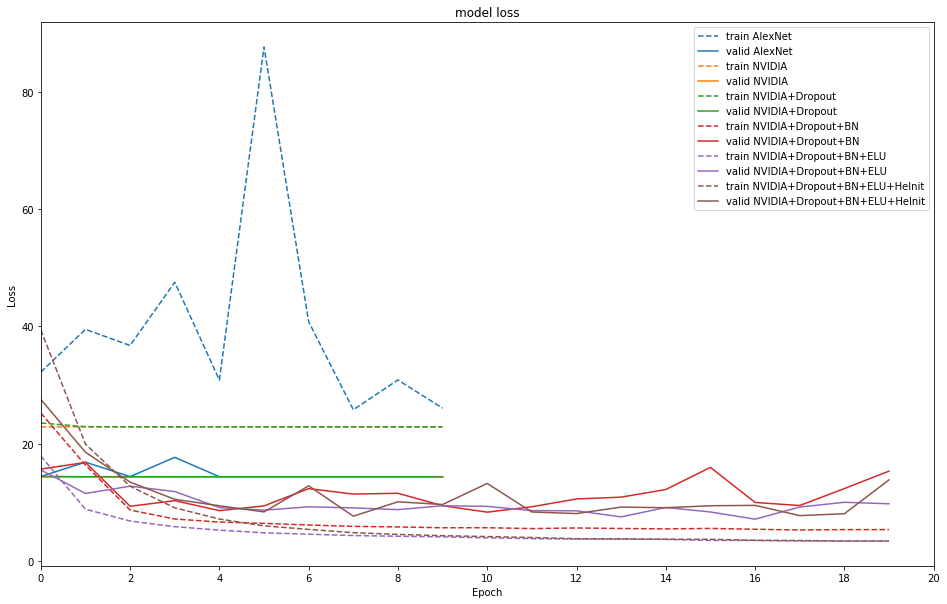

In [30]:
%matplotlib inline



'''

# plt.title('model loss')
plt.ylabel('Loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['train YUV', 'valid YUV', 'train RGB', 'valid RGB', 
            'train YUV shuffle', 'valid YUV shuffle','train RGB shuffle', 'valid RGB shuffle'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.savefig(img_dir + "/base_loss_compare.png", dpi=300)
plt.show()

'''


plt.rcParams['figure.figsize'] = (16,10)


#print(type(history_object))

plt.plot(history_object_alexnet.history['loss'][1:], 'C0--')
plt.plot(history_object_alexnet.history['val_loss'][1:], 'C0')

plt.plot(history_object_base.history['loss'], 'C1--')
plt.plot(history_object_base.history['val_loss'], 'C1')

plt.plot(history_object_reg.history['loss'], 'C2--')
plt.plot(history_object_reg.history['val_loss'], 'C2')

plt.plot(history_object_bn.history['loss'], 'C3--')
plt.plot(history_object_bn.history['val_loss'], 'C3')

plt.plot(history_object_elu.history['loss'][:20], 'C4--')
plt.plot(history_object_elu.history['val_loss'][:20], 'C4')

plt.plot(history_object_he.history['loss'][:20], 'C5--')
plt.plot(history_object_he.history['val_loss'][:20], 'C5')

plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0,20))
plt.xticks(np.arange(0, 21, 2))

plt.legend(['train AlexNet', 'valid AlexNet', 
            'train NVIDIA', 'valid NVIDIA', 
            'train NVIDIA+Dropout', 'valid NVIDIA+Dropout',
            'train NVIDIA+Dropout+BN', 'valid NVIDIA+Dropout+BN', 
            'train NVIDIA+Dropout+BN+ELU', 'valid NVIDIA+Dropout+BN+ELU',
            'train NVIDIA+Dropout+BN+ELU+HeInit', 'valid NVIDIA+Dropout+BN+ELU+HeInit'], 
           loc='upper right')
plt.savefig('model_compare.eps', format='eps', dpi=333)
plt.show()

In [ ]:
model.save('./models/model.h5')

In [72]:
print(history_object.history['loss'])
print(history_object.history['val_loss'])

NameError: name 'history_object' is not defined

In [31]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plt.rcParams['figure.figsize'] = (3, 1)
plot_model(he_model, to_file='elu_model.png', show_shapes=True)
#Image(filename = 'elu_model.png')

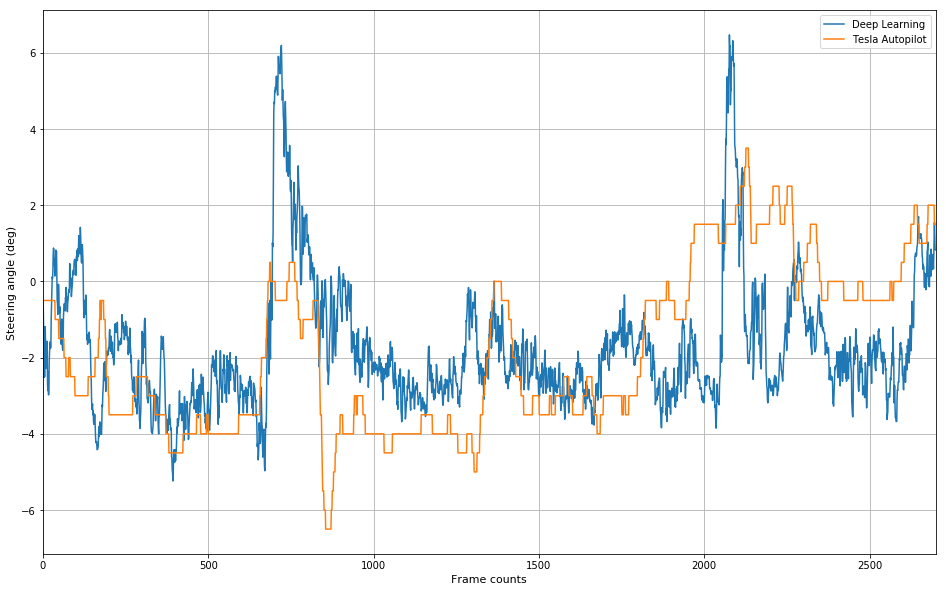

4.88576733884


In [32]:
machine_steering = he_model.predict(X_test, batch_size=128, verbose=0)
plt.rcParams['figure.figsize'] = (16, 10)
plt.figure
plt.plot(machine_steering)
plt.plot(y_test)
plt.ylabel('Steering angle (deg)', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Deep Learning', 'Tesla Autopilot'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig("raw_result.png", dpi=333)
plt.show()

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(machine_steering, y_test)
print(mse)

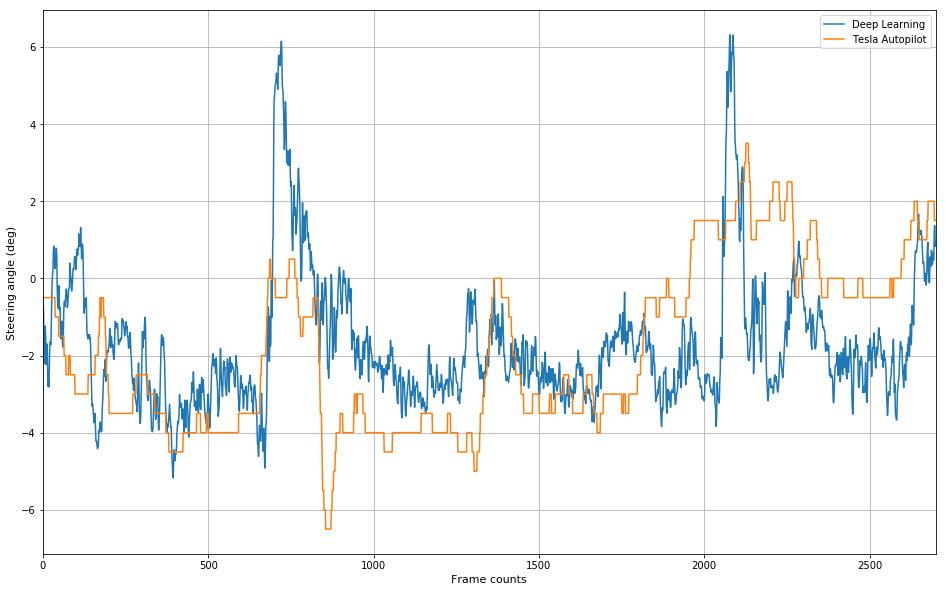

4.86295532151


In [33]:
#machine_steering = he_model.predict(X_test, batch_size=128, verbose=0)
pass_ratio = 0.5
ms_round = []
ms_round.append(machine_steering[0])
for i in range(1, len(machine_steering)):
    ms_round.append(machine_steering[i]*(1-pass_ratio) + machine_steering[i-1]*pass_ratio)
    
#ms_round = [int(x) + 0.5 for x in ms_round]
plt.rcParams['figure.figsize'] = (16, 10)
plt.figure
plt.plot(ms_round)
plt.plot(y_test)
plt.ylabel('Steering angle (deg)', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Deep Learning', 'Tesla Autopilot'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig("conv_result.png", dpi=333)
plt.show()

mse = mean_squared_error(ms_round, y_test)
print(mse)

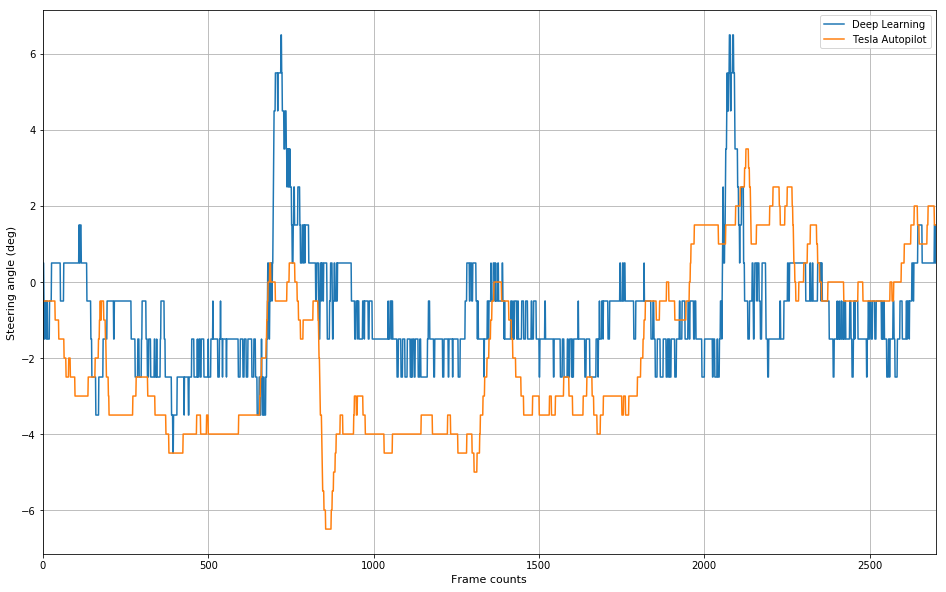

5.51851851852


In [34]:
#machine_steering = he_model.predict(X_test, batch_size=128, verbose=0)
pass_ratio = 0.5
ms_round = []
ms_round.append(machine_steering[0])
for i in range(1, len(machine_steering)):
    ms_round.append(machine_steering[i]*(1-pass_ratio) + machine_steering[i-1]*pass_ratio)
    
ms_round = [int(x) + 0.5 for x in ms_round]
plt.rcParams['figure.figsize'] = (16, 10)
plt.figure
plt.plot(ms_round)
plt.plot(y_test)
plt.ylabel('Steering angle (deg)', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Deep Learning', 'Tesla Autopilot'], loc='upper right')
plt.xlim((0,2700))
plt.grid()
plt.savefig("round_result.png", dpi=333)
plt.show()

mse = mean_squared_error(ms_round, y_test)
print(mse)

In [4]:
model_path = './models/he_model.json'
param_path = './models/model.h5'
with open(model_path, 'r') as in_file:
                json_model = in_file.read()
                model = model_from_json(json_model)
weights_file = os.path.join(param_path)
model.load_weights(weights_file)


/home/meirtz/envs/dl/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


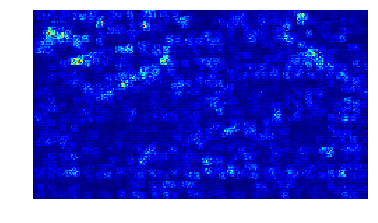

In [27]:
from vis.visualization import visualize_saliency
from vis.utils import utils as kvutils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = kvutils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = kvutils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=0, backprop_modifier='guided', seed_input=X_test[1])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.axis('off')
plt.imshow(grads, cmap='jet')

In [26]:
epoch_ids=[10]
def extract_frames(mode='load'):
    image_set = []
    steerings = []
    image_set_test = []
    steerings_test = []
    for epoch_id in epoch_ids:
        print('---------- processing video for epoch {} ----------'.format(epoch_id))
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(epoch_id))
        csv_path = "./epochs/epoch{:0>2d}_steering.csv".format(epoch_id)
        dir_name = "./epochs/epoch{:0>2d}_front_frames".format(epoch_id)
        steering = pd.read_csv(csv_path)['wheel'].tolist()
        if epoch_id == max(epoch_ids):
            steerings_test.extend(steering)
        else:
            steerings.extend(steering)
        
        if mode == 'save':
            os.mkdir(dir_name)
        frame_ids = pd.read_csv(csv_path)['ts_micro'].tolist()
        assert os.path.isfile(vid_path)
        frame_count = utils.frame_count(vid_path)
        cap = skvideo.io.vreader(vid_path) #cv2.VideoCapture(vid_path)

        machine_steering = []

        print('performing inference...')
        time_start = time.time()
        frame_count = 0
        for img in cap:
            #assert img
            ## you can modify here based on your model
            #print(img.shape)
            #cv2.imshow('frame',img)
            img = img_pre_process2(img)
            if mode == 'save':
                cv2.imwrite("{}/{}.jpg".format(dir_name, frame_ids[frame_count-1]), img)
            elif mode == 'load':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                #img = preprocessing.normalize(img, norm='l2')
                img_f = np.flip(img,1)
                if epoch_id == max(epoch_ids):
                    image_set_test.append(img)
                else:
                    image_set.append(img)
                    image_set.append(img_f)
                #steerings.append(frame_ids[frame_count-1])
            #deg = float(model.predict(img, batch_size=1))
            #machine_steering.append(deg)
            frame_count += 1

        del cap

        fps = frame_count / (time.time() - time_start)
    
        print('completed inference, total frames: {}, average fps: {} Hz'.format(frame_count, round(fps, 1)))
    return np.array(image_set), np.array(steerings), np.array(image_set_test), np.array(steerings_test)
    
        #print('performing visualization...')
        #utils.visualize(epoch_id, machine_steering, params.out_dir,
                            #verbose=True, frame_count_limit=None)
_,_,seeds,_ = extract_frames(mode='load')

---------- processing video for epoch 10 ----------
performing inference...
completed inference, total frames: 2700, average fps: 235.8 Hz


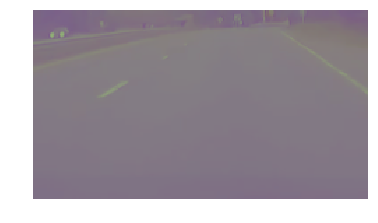

In [32]:
#seed_pic = cv2.cvtColor(X_test[1], cv2.COLOR_YUV2RGB)
#seed_pic = cv2.cvtColor(seed_pic, cv2.COLOR_YUV2RGB)
plt.axis('off')
plt.imshow(seeds[1])